This script load raw radar data saved by TI DCA1000EVM (.bin file) and post-process it through the following steps:

1. Read the raw radar data from the .bin file
2. Re-arrange the data into a shape of `(frames, samples, rx, tx, chirps)`
3. Apply FFT along the `samples` axis to get the range profile
4. Apply FFT along the `chirps` axis to get the Doppler profile
5. Apply FFT along the `antennas` axis to get the azimuth profile

In [96]:
import numpy as np
from enum import Enum
import matplotlib.pyplot as plt

In [97]:
# Parameters Setup
class ADC_CMD(Enum):
    """ADC Command Codes
    This command codes are used to control the DCA1000, obtained from `DCA1000EVM Data Capture Card User's Guide`.
    """
    RESET_FPGA_CMD_CODE = '0100'
    RESET_AR_DEV_CMD_CODE = '0200'
    CONFIG_FPGA_GEN_CMD_CODE = '0300'
    CONFIG_EEPROM_CMD_CODE = '0400'
    RECORD_START_CMD_CODE = '0500'
    RECORD_STOP_CMD_CODE = '0600'
    PLAYBACK_START_CMD_CODE = '0700'
    PLAYBACK_STOP_CMD_CODE = '0800'
    SYSTEM_CONNECT_CMD_CODE = '0900'
    SYSTEM_ERROR_CMD_CODE = '0a00'
    CONFIG_PACKET_DATA_CMD_CODE = '0b00'
    CONFIG_DATA_MODE_AR_DEV_CMD_CODE = '0c00'
    INIT_FPGA_PLAYBACK_CMD_CODE = '0d00'
    READ_FPGA_VERSION_CMD_CODE = '0e00'

    def __str__(self):
        return str(self.value)

In [98]:
MSG_HEADER = 0xA55A
MSG_FOOTER = 0xEEAA
RESPONSE_STATUS = 0x0000
RADAR_PARAMS = {
    'samples': 256,
    'chirps': 128,
    'rx': 4,
    'tx': 2,
    'IQ': 2,  # using both I and Q
    'bytes': 2  # 2 bytes for each I or Q
    }  

MAX_PACKET_SIZE = 4096
BYTES_IN_PACKET = 1456

BYTES_IN_FRAME= (RADAR_PARAMS['chirps'] * RADAR_PARAMS['rx'] * RADAR_PARAMS['tx'] * RADAR_PARAMS['samples'] * RADAR_PARAMS['IQ'] * RADAR_PARAMS['bytes'])  # number of bytes in one frame

BYTES_IN_FRAME_CLIPPED = (BYTES_IN_FRAME // BYTES_IN_PACKET) * BYTES_IN_PACKET
PACKETS_IN_FRAME = BYTES_IN_FRAME / BYTES_IN_PACKET
PACKETS_IN_FRAME_CLIPPED = BYTES_IN_FRAME // BYTES_IN_PACKET
UINT16_IN_PACKET = BYTES_IN_PACKET // 2
UINT16_IN_FRAME = BYTES_IN_FRAME // 2

```python
    # ref: https://github.com/ibaiGorordo/AWR1843-Read-Data-Python-MMWAVE-SDK-3-/blob/master/readData_AWR1843.py
    # Combine the read data to obtain the configuration parameters           
    numChirpsPerFrame = (chirpEndIdx - chirpStartIdx + 1) * numLoops
    configParameters["numDopplerBins"] = numChirpsPerFrame / numTxAnt
    configParameters["numRangeBins"] = numAdcSamplesRoundTo2
    configParameters["rangeResolutionMeters"] = (3e8 * digOutSampleRate * 1e3) / (2 * freqSlopeConst * 1e12 * numAdcSamples)
    configParameters["rangeIdxToMeters"] = (3e8 * digOutSampleRate * 1e3) / (2 * freqSlopeConst * 1e12 * configParameters["numRangeBins"])
    configParameters["dopplerResolutionMps"] = 3e8 / (2 * startFreq * 1e9 * (idleTime + rampEndTime) * 1e-6 * configParameters["numDopplerBins"] * numTxAnt)
    configParameters["maxRange"] = (300 * 0.9 * digOutSampleRate)/(2 * freqSlopeConst * 1e3)
    configParameters["maxVelocity"] = 3e8 / (4 * startFreq * 1e9 * (idleTime + rampEndTime) * 1e-6 * numTxAnt)
```

In [99]:
def dca1000_organize(raw_frame, num_chirps, num_rx, num_tx, num_samples):
    """Reorganize the raw ADC data into a frame.
    
    Args:
        raw_frame: raw ADC data of single frame
        num_chirps: number of chirps per frame
        num_rx: number of receivers
        num_samples: number of ADC samples per chirp

    Returns:
        frame: reformatted frame data with shape (num_chirps, num_rx, num_samples)
    """

    ret = np.zeros(len(raw_frame) // 2, dtype=complex)

    # Separate IQ data
    ret[0::2] = raw_frame[0::4] + 1j * raw_frame[2::4]
    ret[1::2] = raw_frame[1::4] + 1j * raw_frame[3::4]
    return ret.reshape((num_chirps, num_rx, num_tx, num_samples))

In [100]:
BIN_PATH = 'data/adc_data_Tx12.bin'
adc_data = np.fromfile(BIN_PATH, dtype=np.uint16)
print(adc_data.shape)

(524288,)


In [101]:
num_frames = 1  # number of frames to read (defined in mmWare Studio)
adc_data = adc_data.reshape(num_frames, -1)
print(adc_data.shape)

(1, 524288)


In [102]:
adc_data = np.apply_along_axis(dca1000_organize, 1, adc_data, RADAR_PARAMS['chirps'], RADAR_PARAMS['rx'], RADAR_PARAMS['tx'], RADAR_PARAMS['samples'])
print(adc_data.shape)

(1, 128, 4, 2, 256)


In [103]:
adc_data = adc_data.reshape(num_frames, RADAR_PARAMS['chirps'], RADAR_PARAMS['rx'], RADAR_PARAMS['tx'], RADAR_PARAMS['samples'])
adc_data = adc_data.transpose(0, 4, 3, 2, 1)  # (frames, samples, tx, rx, chirps)

# For TI AWR1843 Radar, the third transmitter is used for obtaining the elevation data. (ref MIMO radar layout)
horizontal_tx = 1
if RADAR_PARAMS['tx'] == 3:
    horizontal_tx = 2
    adc_data = adc_data[:, :, 0:2, ...]
else:
    horizontal_tx = RADAR_PARAMS['tx']
print(adc_data.shape)

adc_data = adc_data.reshape(num_frames, RADAR_PARAMS['samples'], horizontal_tx * RADAR_PARAMS['rx'], RADAR_PARAMS['chirps'])  # (frames, samples, antennas, chirps)

(1, 256, 2, 4, 128)


In [104]:
adc_frame0 = adc_data[0]
print(adc_frame0.shape)

(256, 8, 128)


In [105]:
# Range FFT
def range_fft(data, n_sample, hamming_win=False):
    if hamming_win:
        hamming = np.hamming(n_sample)
        win_data = np.zeros([data.shape[0], data.shape[1], data.shape[2]], dtype=np.complex128)
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                win_data[:, i, j] = np.multiply(data[:, i, j], hamming)
    else:
        win_data = data
    fft_data_raw = np.fft.fft(win_data, axis=0)
    fft_data_raw = np.fft.fftshift(fft_data_raw, axes=0)

    return fft_data_raw

In [106]:
# Run Range FFT for frame 0
frame_range_fft = range_fft(adc_frame0, RADAR_PARAMS['samples'], hamming_win=False)

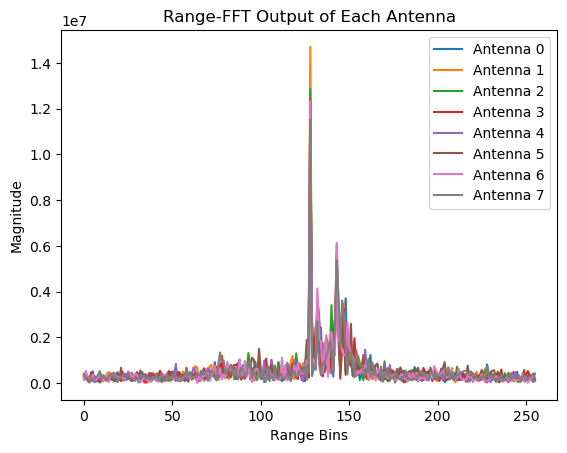

In [107]:
# Plot the magnitude of the range-FFT output of each antenna
plt.figure()
for i in range(horizontal_tx * RADAR_PARAMS['rx']):
    plt.plot(np.abs(frame_range_fft[:, i, 0]), label=f'Antenna {i}')
plt.xlabel('Range Bins')
plt.ylabel('Magnitude')
plt.legend()
plt.title('Range-FFT Output of Each Antenna')
plt.show()

In [108]:
# Doppler FFT
def doppler_fft(data, hamming_win=False):
    """
    Perform Doppler FFT on radar data.

    Args:
        data (ndarray): Input radar data after Range FFT with shape [n_range, n_ant, n_chirp].
        n_vel (int): Number of velocity bins.   

    Returns:
        ndarray: Doppler FFT result with shape [n_range, n_ant, n_doppler].
    """
    if hamming_win:
        hamming_win = np.hamming(data.shape[2])
        win_data = np.zeros([data.shape[0], data.shape[1], data.shape[2]], dtype=np.complex128)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                win_data[i, j, :] = np.multiply(data[i, j, :], hamming_win)
    else:
        win_data = data

    fft_data = np.fft.fft(win_data, axis=2)
    fft_data = np.fft.fftshift(fft_data, axes=2)

    return fft_data

In [109]:
# Run Doppler FFT for frame 0
frame_doppler_fft = doppler_fft(frame_range_fft, hamming_win=False)

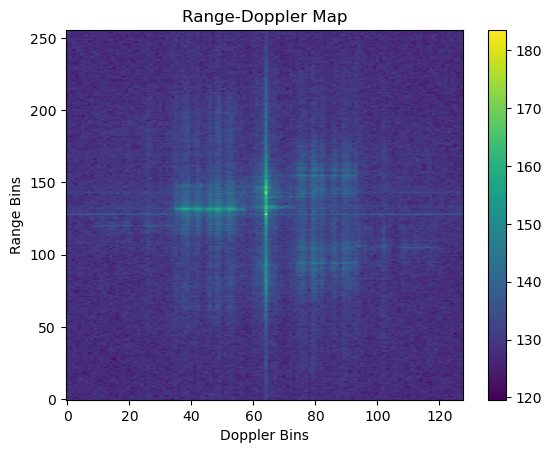

In [110]:
# Plot the Range-Doppler Map by summing the magnitude of the Doppler-FFT output of each antenna
sum_frame_doppler_fft = np.sum(np.abs(frame_doppler_fft), axis=1) / (horizontal_tx * RADAR_PARAMS['rx'])
sum_frame_doppler_fft = 20 * np.log10(sum_frame_doppler_fft)

plt.figure()
plt.imshow(np.abs(sum_frame_doppler_fft), aspect='auto', origin='lower')
plt.xlabel('Doppler Bins')
plt.ylabel('Range Bins')
plt.colorbar()
plt.title('Range-Doppler Map')
plt.show()

In [111]:
# Angle FFT
def angle_fft_on_rd(data, n_ant, n_angle):
    """
    Perform angle FFT on range-Doppler data.

    Args:
        data (ndarray): Input range-Doppler data with shape (n_range, n_ant, n_doppler).
        n_ant (int): Number of antennas.

    Returns:
        ndarray: RAD (Range-Angle-Doppler) data with shape (n_range, n_angle, n_doppler)
    """
    hamming_win = np.hamming(n_ant)
    win_data = np.zeros([data.shape[0], n_ant, data.shape[2]], dtype=np.complex128)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            win_data[i, :, j] = np.multiply(data[i, :, j], hamming_win)

    fft_data = np.fft.fft(win_data, n_angle, axis=1)
    fft_data = np.fft.fftshift(fft_data, axes=1)

    return fft_data

In [112]:
# Run Angle FFT for frame 0
frame_angle_fft = angle_fft_on_rd(frame_doppler_fft, horizontal_tx * RADAR_PARAMS['rx'], 128)
print(frame_angle_fft.shape)

(256, 128, 128)


In [113]:
# Recover the Range-Angle map
def to_ra(data):
    """
    Convert the RAD (Range-Angle-Doppler) data to Range-Angle data.

    Args:
        data (ndarray): Input RAD data with shape (n_range, n_angle, n_doppler).

    Returns:
        ndarray: Range-Angle data with shape (n_range, n_angle).
    """
    data_ra = np.max(np.abs(data), axis=2)
    data_ra = 20 * np.log10(data_ra / np.max(data_ra))
    return data_ra

RAD data (Range-Angle) shape: (256, 128)


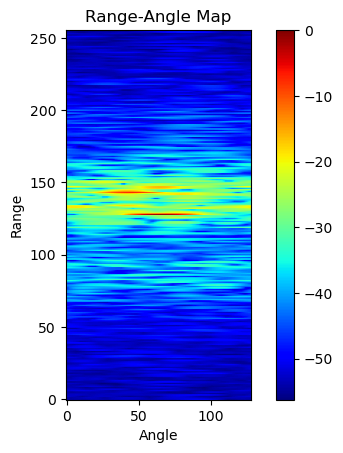

In [114]:
# Convert the RAD data to Range-Angle data
RAD_data_ra = to_ra(frame_angle_fft)
print('RAD data (Range-Angle) shape:', RAD_data_ra.shape)

# Visualize the Range-Angle map, set the origin to the bottom-left corner
plt.imshow(RAD_data_ra, cmap='jet', origin='lower')
plt.colorbar()
plt.xlabel('Angle')
plt.ylabel('Range')
plt.title('Range-Angle Map')
plt.show()

ref: https://github.com/ibaiGorordo/AWR1843-Read-Data-Python-MMWAVE-SDK-3-